# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Загрузим все нужные нам библиотеке, будем дополнять по необходимости

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Откроем файл и изучим общие сведения

In [3]:
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

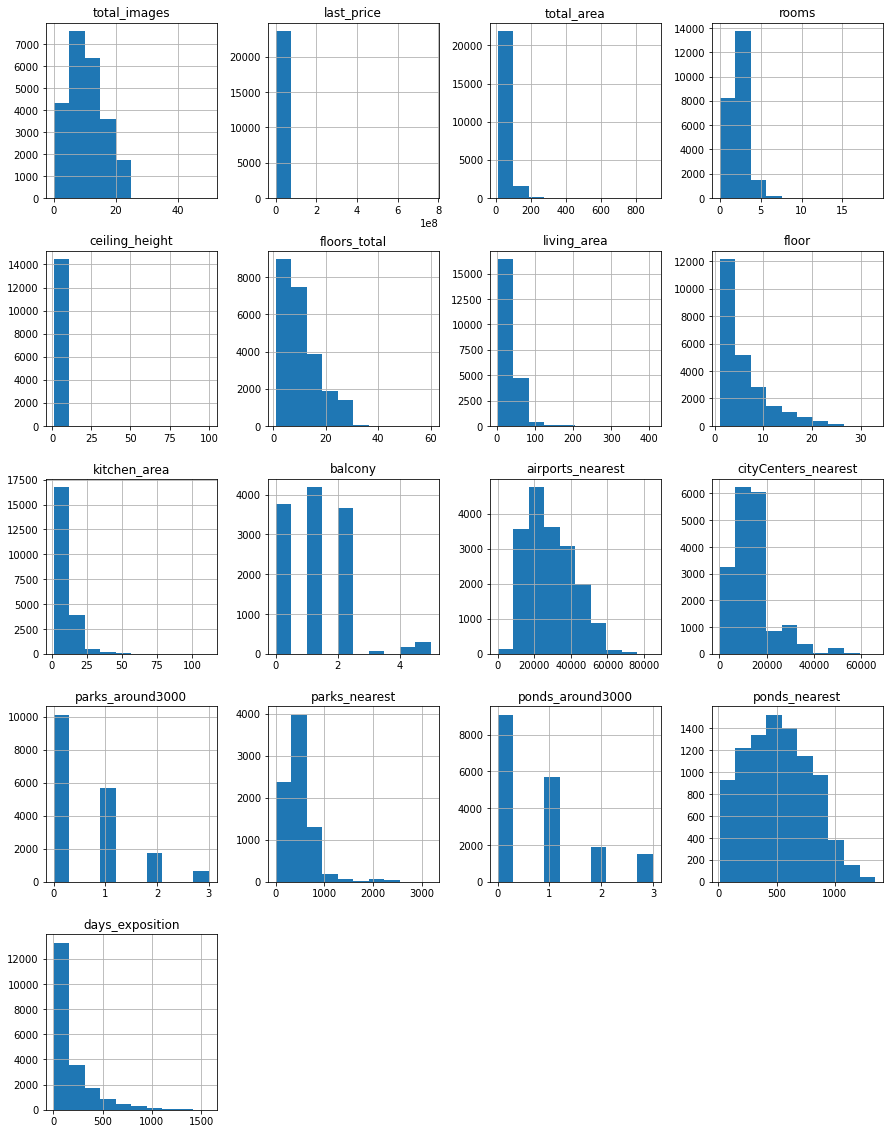

In [4]:
data.hist(figsize=(15, 20));

Построим общую гистограмму для всех столбцов

### Предобработка данных

In [5]:
print(data.isna().sum())
data['balcony'] = data['balcony'].fillna(0).astype('int')
data['is_apartment'] = data['is_apartment'].fillna('True').astype('bool')
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [6]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Проверим изменения, сначала проверим пропуски

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Теперь проверим изменения в типах данных

In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT')
data = data.dropna(subset=['floors_total'])
data[['last_price', 'floors_total']] = data[['last_price', 'floors_total']].astype('int32')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int32         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int32         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

Рассмотрим типы данных в каждом столбце  
Изменим тип данных в столбцах first_day_exposition и floors_total

In [9]:
data['locality_name'].unique()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].replace('посёлок |деревня | село |поселок |посёлок городского типа |поселок городского типа |садовое товарищество |садоводческое некоммерческое товарищество | городского типа |городской ', '', regex=True)

Изучим уникальные значения в столбце с названиями и устраним дубликаты  

In [10]:
data['ceiling_height'].unique()
data.loc[data['ceiling_height'] > 8.3, 'ceiling_height'] /= 10

В столбце ceiling_height заменим все аномальные значения выше 8,3

In [11]:
data['last_price'].unique()
data.loc[data['last_price'] > 9000000, 'last_price'] /= 10
data.loc[data['last_price'] < 1000000, 'last_price'] *= 10

In [12]:
data['rooms'].unique()
data = data.loc[data['rooms'] <= 6]

In [13]:
print(data['total_area'].unique())
data = data[(data['total_area'] <= 140) & (data['total_area'] >= 25)] 
data = data.dropna(subset=['total_area'])

[108.    40.4   56.   ...  66.86 133.81  76.75]


### Посчитайте и добавьте в таблицу новые столбцы

In [16]:
data['price_sq_m'] = data['last_price']/ data['total_area']
data['price_sq_m'] = data['price_sq_m'].astype('int')
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

data.insert(26, 'floor_type', np.nan)
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'
data['floor_type'] = data['floor_type'].fillna(value='другой')
    
data = data.dropna(subset=['cityCenters_nearest'])
data['city_centers_group'] = data['cityCenters_nearest']/1000
data['city_centers_group'] = data['city_centers_group'].astype('int')

print(data.head(20))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20   1300000.0       108.0           2019-03-07      3   
1              7   3350000.0        40.4           2018-12-04      1   
2             10   5196000.0        56.0           2015-08-20      2   
4              2   1000000.0       100.0           2018-06-19      2   
6              6   3700000.0        37.3           2017-11-02      1   
7              5   7915000.0        71.6           2019-04-18      2   
9             18   5400000.0        61.0           2017-02-26      3   
10             5   5050000.0        39.6           2017-11-16      1   
11             9   3300000.0        44.0           2018-08-27      2   
13            20   3550000.0        42.8           2017-07-01      2   
14             1   4400000.0        36.0           2016-06-23      1   
15            16   4650000.0        39.0           2017-11-18      1   
16            11   6700000.0        82.0           2017-11-23   

Добавьим в таблицу новые столбцы со следующими параметрами:  
цена одного квадратного метра - price_sq_m  
день недели публикации объявления - weekday  
месяц публикации объявления - month  
год публикации объявления - year  
тип этажа квартиры — floor_type и заполним этот столбец параметрами «первый», «последний», «другой»  
расстояние до центра города в километрах - city_сenters_group

### Проведите исследовательский анализ данных

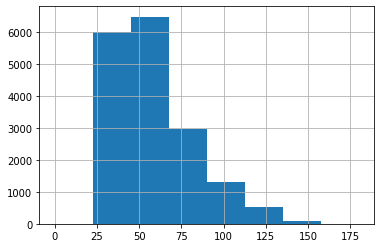

In [17]:
data['total_area'].hist(bins=8, range=(0, 180));

На графике с общей площадью мы видим что свыше 6000 квартир от 40 до 60 кв. метров, примерно 6000 квартир с площадью 25-40 кв м и вдвое меньше квартир с площадью 60-80 кв м. Квартир с площадью 80-110 кв м около 1200 шт, а с площадью 110-135 - 500 шт и совсем мало квартир с площадью 135-140 кв метров - 100 шт.

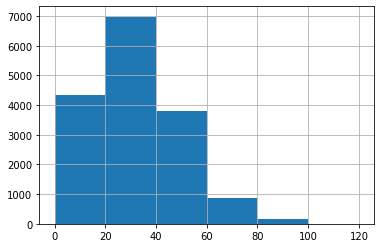

In [18]:
data['living_area'].hist(bins=6, range=(0, 120));

Видим, что:
квартир с жилой площадью 20-40 кв. метров больше всего - 7000 шт, с жилой площадью 0-20 квадратов примерно 4300 шт, с площадью 40-60 квадратов - 3800 штук, квартир с жил.площадью 60-80 квадратов около 800 штук и совсем мало квартир с жилой площадью 80-100 метров, около 100 шт

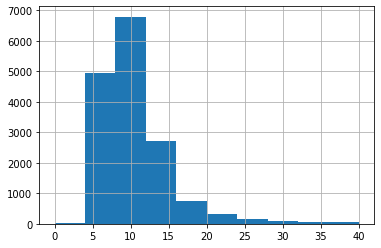

In [19]:
data['kitchen_area'].hist(bins=10, range=(0, 40));

Больше всего кухонь с площадью 8-11 квадратов - 6800, кухонь с параметрами 4-8 кв метров - 4900 шт, кухонь с площадью 11-16 кв м - 3700, с площадью 16-20 кв м - 700 шт, с площадью 20-23 кв м - 300 шт, кухонь с плоащдью 23-40 - около 100 шт.

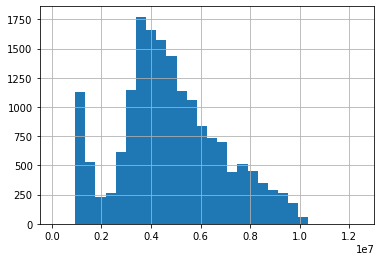

In [20]:
data['last_price'].hist(bins=30);

В столбце с стоимостью квартиры больше всего квартир в диапозоне 0,3-0,4. На графике видно, что идет постепенное увеличение стоимости уменьшение таких предложений. При этом заметен пик в районе 0,1 - возможно это большое количество квартир с невысокой стоимостью в отдаленных городах вокруг Санкт-Петербурга.

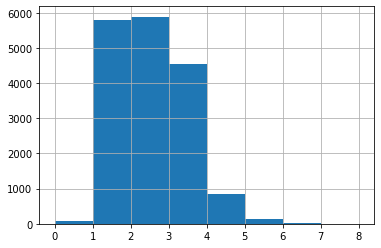

In [21]:
data['rooms'].hist(bins=8, range=(0, 8));

По графику видим почти одинаковое количество 1/2/3- комнатных квартир, в районе 5800,  
4 комнатных квартир примерно 4,5 тысячи, 5 комнатных около 800 и 6 и более - менее 100 шт.

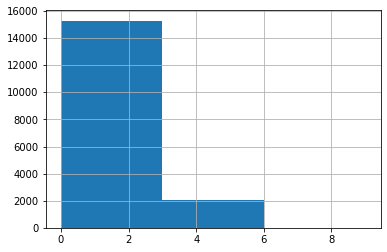

In [22]:
data['ceiling_height'].hist(bins=3, range=(0, 9));

По графику видим что высота потолоков почти во всех квартирах лежит в диапозоне 2-2,7 метра и их одинаковое количество, а именно - 15600 шт. Ещё примерно в 2000 квартир высота потолков равна 2,7-6 метров.

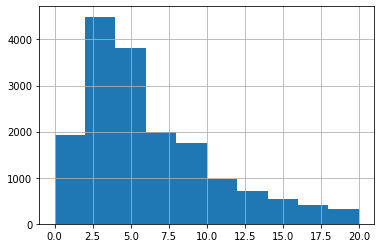

In [23]:
data['floor'].hist(bins=10, range=(0, 20));

Квартир на 2-4 этажах больше всего - 4800 шт, квартир на 5-6 этажах чуть меньше 3800 шт, квартир на 1 и на 6-8 этажах около 2000, 8-10 этажах примерно 1800 шт, 10-12 - 1000 шт, 12-14 - 600 шт, 14-16 этажах - 500 шт, 16 и выше около 400 шт.

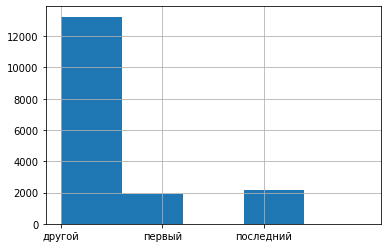

In [24]:
data['floor_type'].hist(bins=5, range=(0, 3));

На графике видно, что предложений на "других" этажах почти 13 тысяч, в то время как "первого" и "последнего" - всего около 2000 шутк

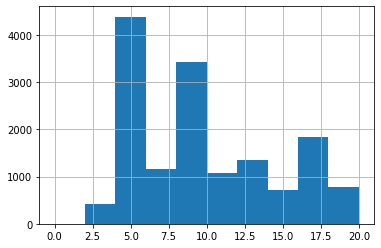

In [25]:
data['floors_total'].hist(bins=10, range=(0, 20));

Больше всего квартир в 4-6 этажных домах - таких 4500, 8-10 этажных - 3500, 16-18 этажных домов около 1800 шт, 12-14 этажных домов 1300 шт, 6-8 этажных и 10-12 этажных домов по 1100, 14-16 этажных и 18-20 этажных домов по 800 шт и ещё примерно 400 домов 2-4 этажных.

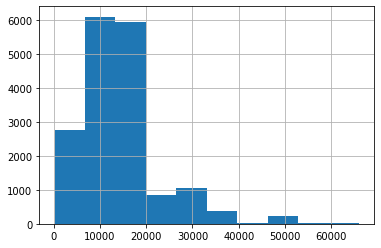

In [26]:
data['cityCenters_nearest'].hist(bins=10);

Больше всего вариантов в отдаленности 8000 - 20000 м от центра, таких 6000, предложений в 0-8000 м от центра 2800, в 27000-33000 примерно 1100 квартир, 800 квартир в 20000-27000 м от центра, и в 37000 и более примерно 400 квартир.

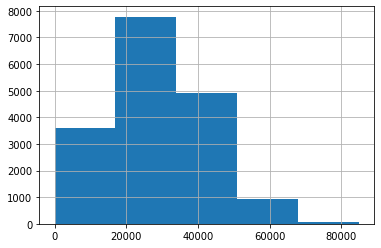

In [27]:
data['airports_nearest'].hist(bins=5);

В 18000-37000 м от аэропорта расположено наибольшее число квартир, а именно 7800, в отдаленности 37000-50000 расположено 5000 квартир, 4600 квартир находятся на расстоянии 0-20000 м от аэропорта, и примерно 1000 кв находятся в 50000 м от аэропорта и дальше.

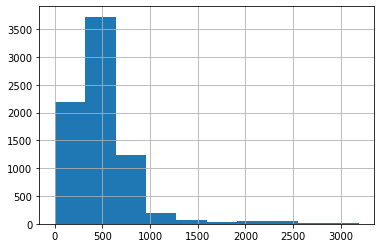

In [28]:
data['parks_nearest'].hist(bins=10);

Больше всего квартир расположено на расстоянии 400-600 м от ближайшего парка - 3800,  2200 квартир находятся в 0-400 м от парка, 1300 квартир расположены в 600-950 метрах от парка. В 950 и более расположено чуть более 200-х сот квартир.

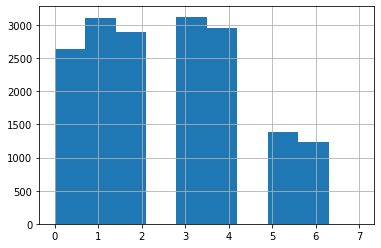

In [29]:
data['weekday'].hist(bins=10, range=(0, 7));

Больше всего объявлений было опубликовано во вторник и четверг, таких было по 3200 шт, ещё около 3000 шт было опубликовано в среду и пятницу, в понедельник было опубликовано примерно 2600 объявлений и по суббота и воскресеньям 1400 и 1300 объявлений соответсвенно.

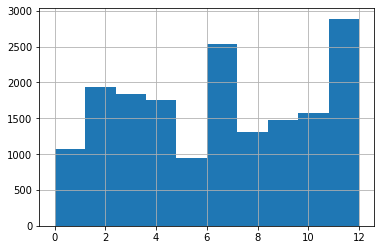

In [30]:
data['month'].hist(bins=10, range=(0, 12));

Больше всего размещено объявлений в декабре - 3300, с февраля по май примерно одинаковое количество объявлений каждый месяц около 1800 шт, с июля по сентябрь около 1300 объявлений в месяц, в октябре и ноябре около 1500, в январе и июне по 1000 объявлений.

count    15208.000000
mean       178.811941
std        219.617174
min          1.000000
25%         43.000000
50%         94.000000
75%        226.250000
max       1572.000000
Name: days_exposition, dtype: float64


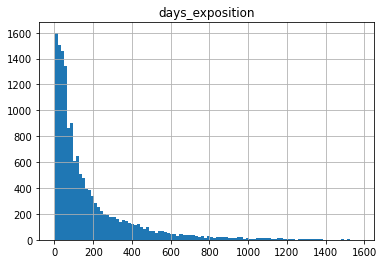

In [31]:
data.hist(column='days_exposition', bins=100)
print(data['days_exposition'].describe())

В среднем продажа занимает 96 дней. Быстрыми продажа можно считать те, которые произошли в течение 30 дней. На нашем графике таких большинство. Долгими продажами можно считать те, что висели 200 и более дней.

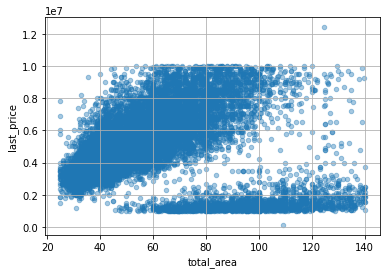

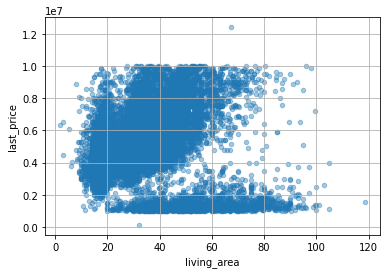

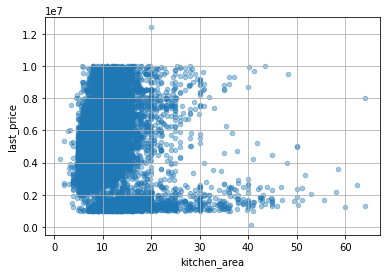

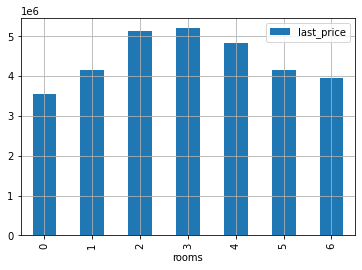

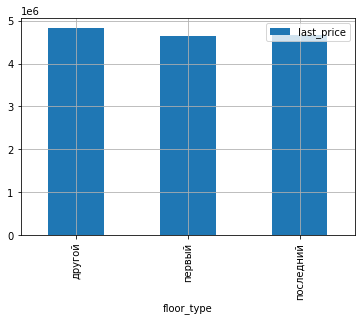

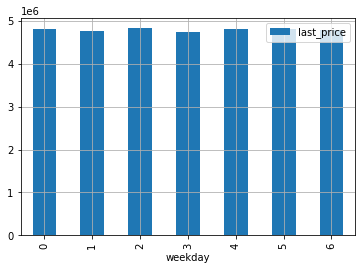

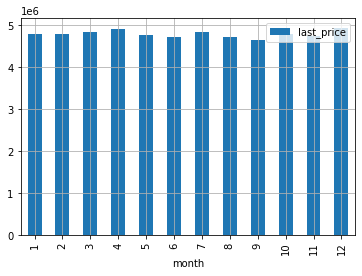

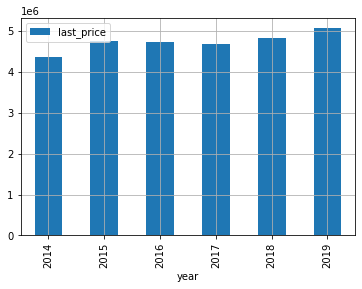

In [32]:
data.plot(x='total_area', y='last_price', kind='scatter', grid=True, alpha=0.4)
data.plot(x='living_area', y='last_price', kind='scatter', grid=True, alpha=0.4)
data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, alpha=0.4)

rooms_stat = data.pivot_table(index='rooms', values='last_price', aggfunc='mean')
rooms_stat.plot(kind='bar', grid=True)

floor_type_stat = data.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
floor_type_stat.plot(kind='bar', grid=True)

weekday_stat = data.pivot_table(index='weekday', values='last_price', aggfunc='mean')
weekday_stat.plot(kind='bar', grid=True)

month_stat = data.pivot_table(index='month', values='last_price', aggfunc='mean')
month_stat.plot(kind='bar', grid=True)

year_stat = data.pivot_table(index='year', values='last_price', aggfunc='mean')
year_stat.plot(kind='bar', grid=True);

Изучим, зависит ли цена от:  
от общей площади цена зависит, но мы можем сказать что есть значительное количество примеров, где с увеличением площади цена не увеличивается, можем сделать вывод, что есть третий фактор влиящий на стоимость 
от жилой площади цена зависит больше, нежели от общей, но также есть исключения  
с увеличением площади кухни увеличивается и цена, график отражает это, но всё ещё множество исключений
до 3 комнатных квартир график показывает увеличение стоимости, однако с 4 комнатных квартир стоимость уменьшается, можем сделать вывод, что есть третий фактор влиящий на стоимость  
мы видим, что цена не значительно отличается в зависимости от этажа, на котором расположена квартира (первый, последний, другой)  
мы наблюдаем, что день недели и месяц влияют не существенно на стоимость квартиры, в то время как год старта продажи сказывается на цене. Предположу, что это связано с инфляцией.

In [33]:
df_corr = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']].corr()
print(df_corr)

              last_price  total_area  living_area  kitchen_area     rooms
last_price      1.000000    0.088296     0.110165     -0.009956  0.162731
total_area      0.088296    1.000000     0.912964      0.535068  0.781937
living_area     0.110165    0.912964     1.000000      0.255299  0.874500
kitchen_area   -0.009956    0.535068     0.255299      1.000000  0.140977
rooms           0.162731    0.781937     0.874500      0.140977  1.000000


Рассчитаем корреляцию стоимости от общей площади, жилой площади, площади кухни и количества комнат.  
Из полученных сведений можем сделать следующие выводы:  
для стоимости: ни один из изученных нами условий не имеет достаточной высокой поожительной корреляции, чтобы говорить об устойчивой взаимосявзи. Наибольшая корреляция наблюдается в связи с количеством комнат, но она всего лишь 0,16.  
для общей площади: наблюдается высокая крреляция с жилой площадью и количеством комнат - 0,91 и 0,78 соответсвенно.  
для жилой площади: характерна уже упомянутая корреляция с общей площадью (0,91) и количеством комнат - 0,87.  
для площади кухни: не наблюдается ни одной устойчивой связи, наибольшая корреляция 0,53 с общей площадью.  
для количества комнат: корреляция существует с общей площадью (0,78) и жилой площадью (0,87).

In [34]:
popular_location = data.groupby('locality_name').agg({'price_sq_m':['count','mean']})
popular_location.columns = ['count', 'price per m pop']
popular_location = popular_location.sort_values(by='count', ascending=False)

print(popular_location.head(15))

                 count  price per m pop
locality_name                          
Санкт-Петербург  14864     92295.825484
Шушары             432     77617.951389
Пушкин             356     93326.196629
Колпино            335     74880.576119
Парголово          325     90430.298462
Петергоф           197     81637.654822
Сестрорецк         181     91174.662983
Красное Село       172     72155.563953
Ломоносов          132     72609.386364
Кронштадт           94     78106.797872
Металлострой        66     73751.939394
Стрельна            41     86047.585366
Павловск            36     75259.694444
Зеленогорск         23     90138.478261
Понтонный           20     70104.050000


Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра и сохраним их в popular_location.  
Из населенных пунктов с наибольшим количеством объявлений можем сказать, что наибольшая стоимость квадратного метра в городе Пушкин и составляет 93326р. Наименьшая стоимость квадратного метра из нашей выборки в г. Понтонный и составляет 70104р.

city_centers_group
0     5.038194e+06
1     4.715906e+06
2     5.348459e+06
3     5.120819e+06
4     4.826950e+06
5     5.268686e+06
6     4.977356e+06
7     5.069615e+06
8     4.843941e+06
9     4.778164e+06
10    4.708864e+06
11    4.930002e+06
12    4.768677e+06
13    5.062620e+06
14    4.949131e+06
15    4.869736e+06
16    4.739609e+06
17    4.515217e+06
18    4.548366e+06
19    4.593212e+06
20    5.827839e+06
21    4.921474e+06
22    4.996741e+06
23    4.126867e+06
24    3.862235e+06
25    4.048664e+06
26    3.575000e+06
27    1.842500e+06
28    4.910500e+06
29    3.833333e+06
Name: last_price, dtype: float64

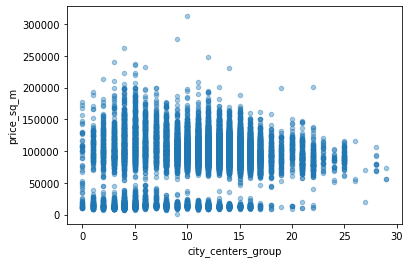

In [35]:
spb_stat = data.query('locality_name == "Санкт-Петербург"')
spb_stat.plot(x='city_centers_group', y='price_sq_m', kind='scatter', alpha=0.4) 
spb_stat.groupby('city_centers_group')['last_price'].mean()

Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Оценим, как стоимость объектов зависит от расстояния до центра города. По нашим результатам можем отметить, что до чем ближе к центру, тем дороже стоит квадратный метр. В пределах 7 км от центра стоимость квадратного метра наиболее высокая и составляет в среднем 200 тыс рублей (разброс от 180 до 260 тыс за кв м). Ещё один пик наблюдается на расстоянии 13 км от центра и составляет 180 тыс за кв метр. С 13 км стоимость квадратного метра падает при удалении от центра.

### Общий вывод

Было проведено исследование для установления взаимосвязи разных условий на полную стоимость квартиры.  
Исходные данные: база объявлений со сроками продажи квартир за 4 года (с 2014 по 2018 года).  
  
 Перед проведением исследования перед нами были поставлены вопросы, из которых мы вывели следующие гипотезы:

* **Гипотеза 1:** общая плоащдь влияет на стоимость квартиры; 
* **Гипотеза 2:** жилая площадь влияет на стоимость квартиры;
* **Гипотеза 3:** площадь кухни влияет на стоимость квартиры;
* **Гипотеза 4:** количество комнат влияет на стоимость квартиры;
* **Гипотеза 5:** этаж, на котором расположена квартира, влияет на стоимость квартиры;
* **Гипотеза 6:** дата размещения влияет на стоимость квартиры;
* **Гипотеза 7:** удаленность от центра города влияет на стоиомость квартиры в Санкт-Петербурге.
    
В результате удалось найти следующие зависимости.  

**Гипотеза 1.** 
    Данная гипотеза подтверждается частично. 
Действительно общая площадь влияет на стоимость квартиры, однако на графике мы видим, что есть много предложений в которых с увеличением площади стоимость растет незначительно или не растет вовсе.
        
Рекомендация: зависимость есть, при этом есть и множество исключений, поэтому брать этот критерий за основополагающий для установления стоимости не стоит. Вероятно есть другие факторы, больше влияющие на стоимость квартиры, нежели общая площадь.

**Гипотеза 2.**    
     Данная гипотеза подтверждается частично. 
Действительно жилая площадь влияет на стоимость квартиры, однако на графике мы видим, что есть много предложений в которых с увеличением площади стоимость растет незначительно.  

Рекомендация: зависимость есть, но есть и множество исключений, поэтому брать этот критерий за основополагающий для установления стоимости не стоит.

**Гипотеза 3.**     
    Данная гипотеза подтверждается частично. 
Действительно площадь кухни влияет на стоимость квартиры, однако на графике мы видим, что есть квартиры, в которых с увеличением площади кухни стоимость растет несильно.  

Рекомендация: гипотеза подтверждается только частично, считаю брать данный критерий как основопологающий для установления стоимости невозможно.
        
**Гипотеза 4.**     
    Данная гипотеза подтверждается частично. 
Действительно количество комнат влияет на стоимость квартиры и с увеличением комнат квартира растет в цене. Однако мы видим, что есть объекты, в которых с увеличением количества комнат, стоимость не растет. 

Рекомендация: гипотеза подтверждается частично, считаю можно брать данный критерий в качестве дополнительного.  
  
**Гипотеза 5.**     
    Данная гипотеза не подтверждается. 
Стоимость квартиры не зависит от этажа, на котором расположена. Квартиры на первом этаже и на последнем стоят незначительно меньше. 
  
Рекомендация: гипотеза не подтверждается, брать данный критерий для установления стоимости не рекомендую.
  
**Гипотеза 6.**     
    Данная гипотеза подтверждается частично. 
Стоимость квартиры не зависит от дня недели и месяца, в котором было размещено объявление о её продаже. Год продажи немного влияет на стоимость квартиры, исключительно из-за инфляции.   
  
Рекомендация: можем сделать вывод, что данные критерии для установления стоимости не стоит.  

**Гипотеза 7.**     
    Данная гипотеза подтверждается. 
Действительно стоимость квартиры зависит от её расположения и удаленности от центра городамы видим, что с увеличением растояния от центра падает и стоимость квадратного метра.   
  
Рекомендация: гипотеза подтверждается, считаю данный критерий можно взять за основопологающий для установления стоимости квартиры. 

**Общие выводы:**
Считаю можно расстояние до центра в качестве основополагающего критерия для установления стоимости квартиры. А также количетсво комнат, общую площадь, жилую площадь, площадь кухни брать в качестве дополнительных критериев.